<a href="https://colab.research.google.com/github/sogand73/OCT-Classification/blob/main/representative_dictionary_learning_for_OCT(Macular_Dataset_Heidelberg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from PIL import Image
import cv2
import shutil
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import MiniBatchDictionaryLearning
from joblib import dump, load

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Data preparing for Dictionary Learning

In [6]:
!sudo apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [7]:
# Dataset collected from Macular Dataset Heidelberg --------> 600 train (100 validation), 200 test for each class
!unrar x '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar

Creating    Dataset                                                   OK
Creating    Dataset/Test                                              OK
Creating    Dataset/Test/AMD                                          OK
Extracting  Dataset/Test/AMD/1.TIFF                                        0%  OK 
Extracting  Dataset/Test/AMD/100.TIFF                                      0%  OK 
Extracting  Dataset/Test/AMD/1000.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1018.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1021.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1022.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1026.TIFF                 

In [ ]:
# @title Selection of some images as the dataset for dictionary learning (open and store)

In [3]:
shutil.rmtree('/content/oct_my_dictl_dataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_dictl_dataset'

In [4]:
!mkdir '/content/oct_my_dictl_dataset'


In [5]:
#classes = ['NORMAL', 'DME', 'DRUSEN', 'CNV']
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  dictl_subfolder = os.path.join('/content/oct_my_dictl_dataset/',subfolder)

  os.makedirs(dictl_subfolder, exist_ok=True)

In [8]:
# Define source and destination directories
#dataset_folder = '/content/OCT2017 /train/'  # Replace with your source folder path
dataset_folder = '/content/Dataset/Train/'

destination_folder = '/content/oct_my_dictl_dataset/'  # Replace with your destination folder path
images =[]
for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for file_name in files_to_copy[:20]:
    if file_name.endswith('.TIFF'):  # Specify the image file formats
          source_path = os.path.join(source_folder, file_name)
          destination_path = os.path.join(destination_folder, subfolder) + '/'
          shutil.copy(source_path, destination_path)
          img = Image.open(os.path.join(destination_path, file_name)) # This returns an image object
          #print(img.mode)
          #img = img.convert('RGB')
          img = np.asarray(img) # convert it to ndarray
          img = cv2.resize(img, (512, 512))
          images.append(img)
#return np.array(images)
          #print(f"Copied: {file_name}")






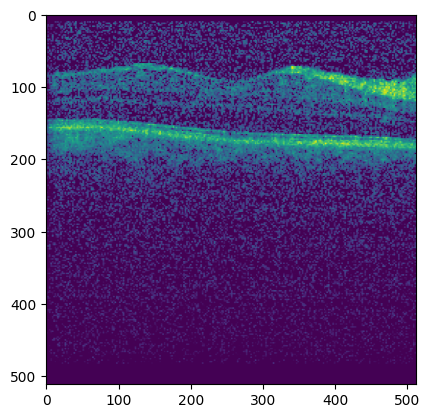

In [9]:
plt.imshow(images[1])

In [ ]:
#@title dictionary Learning Processs

In [10]:
# Load dictionary learning images
image_data = np.asarray(images)
n_images, height, width = image_data.shape

In [11]:
# Flatten the image data
X = image_data.reshape((n_images, height * width))

# Explicitly cast the array to float before division
X = X.astype(float)

# Rescale pixel values to the range [0, 1] for MiniBatchDictionaryLearning
X /= 255.0


# CLASSES: 'NORMAL', 'DME', 'AMD'
#X_NORMAL, X_DME, X_AMD = X[:10], X[10:20], X[20:30]
X_NORMAL, X_DME, X_AMD = X[:20], X[20:40], X[40:60]

In [12]:
# Create a dictionary learning model for NORMAL data
n_components = 10**2  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 60  # Number of iterations (old:100)

dl_model_NORMAL = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

# #Normalized data
# X_NORMAL -= np.mean(X_NORMAL, axis=0)
# X_NORMAL /= np.std(X_NORMAL, axis=0)

# Fit the model to the flattened NORMAL image data
dl_model_NORMAL.fit(X_NORMAL)
ATOMS_NORMAL = dl_model_NORMAL.components_
X_NORMAL_tr = dl_model_NORMAL.transform(X_NORMAL)

#save the model
dump(dl_model_NORMAL, '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/dl_model_NORMAL_10_60.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


['/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/dl_model_NORMAL_10_60.joblib']

In [13]:
# Create a dictionary learning model for DME data
n_components = 10**2  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 60  # Number of iterations (old:100)

dl_model_DME = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

#Normalized data
# X_DME -= np.mean(X_DME, axis=0)
# X_DME /= np.std(X_DME, axis=0)

# Fit the model to the flattened DME image data
dl_model_DME.fit(X_DME)
ATOMS_DME = dl_model_DME.components_
X_DME_tr = dl_model_DME.transform(X_DME)

#save the model
dump(dl_model_DME, '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/dl_model_DME_10_60.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


['/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/dl_model_DME_10_60.joblib']

In [14]:
# Create a dictionary learning model for AMD data
n_components = 10**2  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 60  # Number of iterations (old:100)

dl_model_AMD = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

#Normalized data
# X_AMD -= np.mean(X_AMD, axis=0)
# X_AMD /= np.std(X_AMD, axis=0)

# Fit the model to the flattened AMD image data
dl_model_AMD.fit(X_AMD)
ATOMS_AMD = dl_model_AMD.components_
X_AMD_tr = dl_model_AMD.transform(X_AMD)

#save the model
dump(dl_model_AMD, '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/dl_model_AMD_10_60.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


['/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/dl_model_AMD_10_60.joblib']

In [15]:
!mkdir '/content/atoms'


In [16]:
classes = ['NORMAL', 'DME', 'AMD']
for subfolder in classes:
  dictl_subfolder = os.path.join('/content/atoms/',subfolder)

  os.makedirs(dictl_subfolder, exist_ok=True)

In [17]:

#atoms save as an image

for atom in [[ATOMS_NORMAL,'NORMAL'], [ATOMS_DME,'DME'], [ATOMS_AMD,'AMD']]:
  for i in range(n_components):
    atoms_save = atom[0][i].reshape((512, 512))*255
    atoms_save = atoms_save.astype(np.uint8)
    destination_atom_folder = os.path.join('/content/atoms/', atom[1], str(i)+'.jpeg')
    cv2.imwrite(destination_atom_folder, atoms_save)

0.3965
1.706095666517735e-12


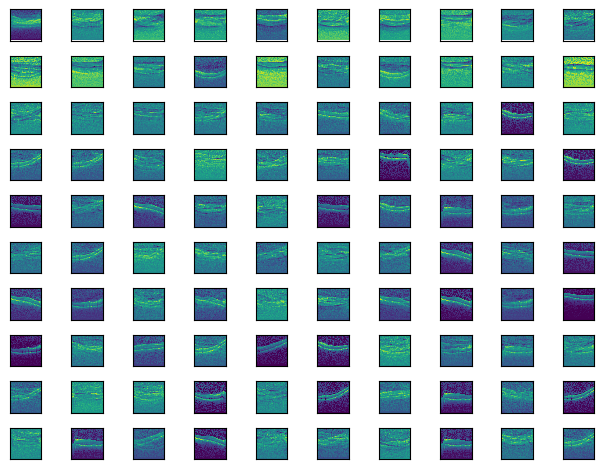

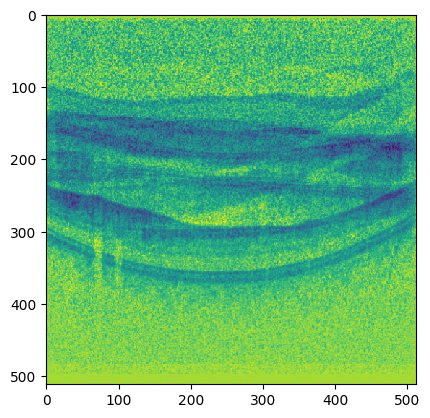

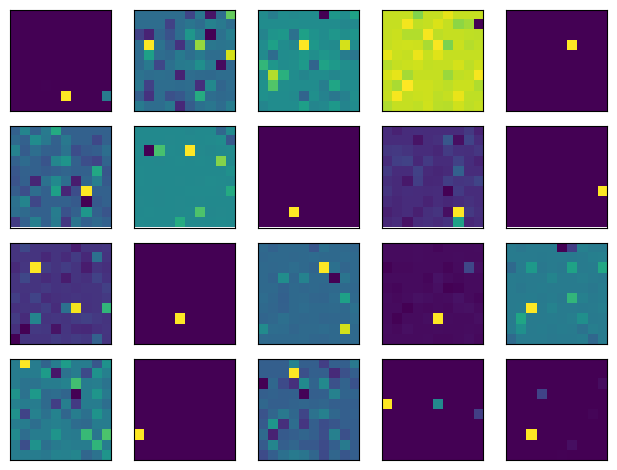

In [18]:
#NORMAL data

#Feature extraction percent
print(np.mean(X_NORMAL_tr == 0))
X_NORMAL_hat = X_NORMAL_tr @ dl_model_NORMAL.components_
print(np.mean(np.sum((X_NORMAL_hat - X_NORMAL) ** 2, axis=1) / np.sum(X_NORMAL ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_NORMAL
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[10].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_NORMAL_tr
fig, axes = plt.subplots(nrows=4, ncols=5)
axes = axes.flatten()

for i in range(X_NORMAL_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


0.48
1.6792079467221657e-12


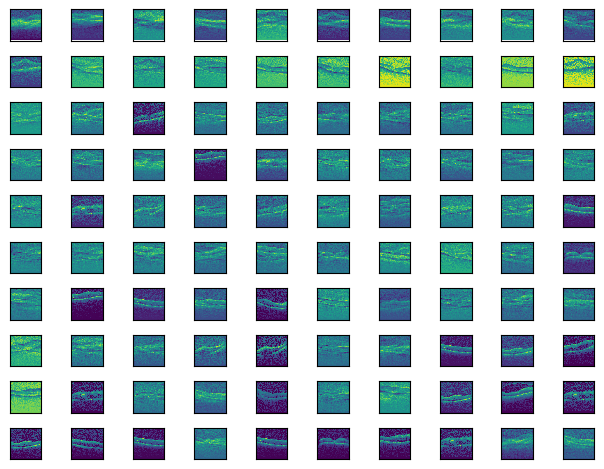

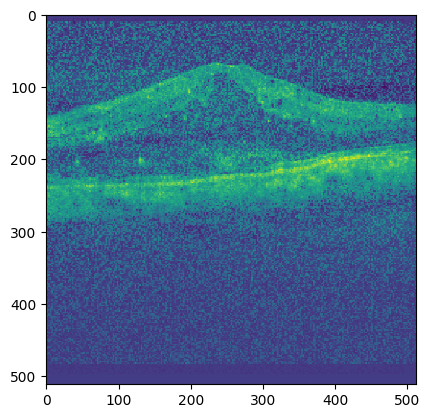

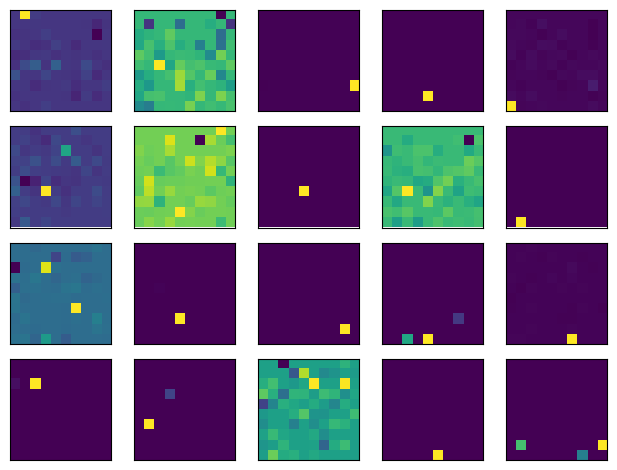

In [19]:
#DME data

#Feature extraction percent
print(np.mean(X_DME_tr == 0))
X_DME_hat = X_DME_tr @ dl_model_DME.components_
print(np.mean(np.sum((X_DME_hat - X_DME) ** 2, axis=1) / np.sum(X_DME ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_DME
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[10].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_DME_tr
fig, axes = plt.subplots(nrows=4, ncols=5)
axes = axes.flatten()

for i in range(X_DME_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


0.408
3.422525078725704e-12


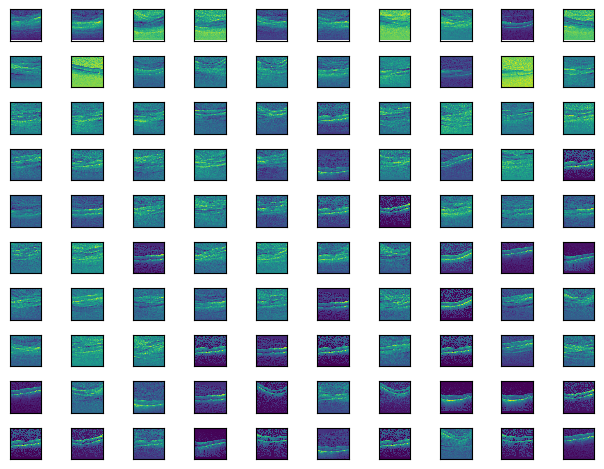

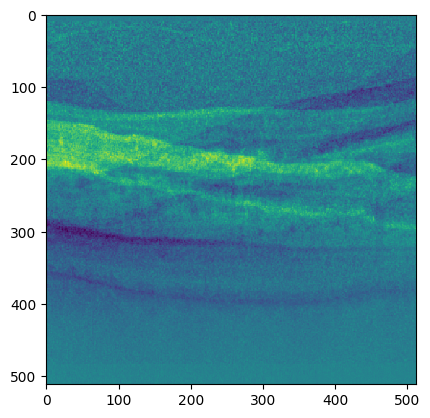

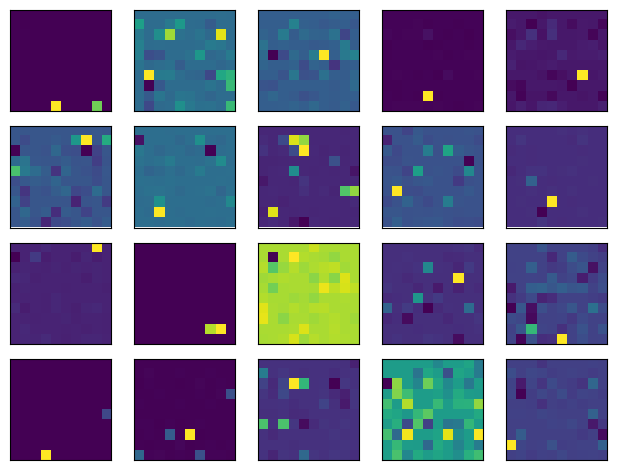

In [20]:
#AMD data

#Feature extraction percent
print(np.mean(X_AMD_tr == 0))
X_AMD_hat = X_AMD_tr @ dl_model_AMD.components_
print(np.mean(np.sum((X_AMD_hat - X_AMD) ** 2, axis=1) / np.sum(X_AMD ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_AMD
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[10].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_AMD_tr
fig, axes = plt.subplots(nrows=4, ncols=5)
axes = axes.flatten()

for i in range(X_AMD_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [ ]:
#@title Classification using YOLOv8

In [21]:
shutil.rmtree('/content/oct_my_dataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_dataset'

In [22]:
import os
!mkdir '/content/oct_my_dataset'
!mkdir '/content/oct_my_dataset/Train'
!mkdir '/content/oct_my_dataset/Test'
!mkdir '/content/oct_my_dataset/Val'


In [23]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_dataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_dataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_dataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [24]:
import shutil


# Define source and destination directories
dataset_folder = '/content/Dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/'  # Replace with your destination folder path

#for folder in [['Train/',500], ['Test/',200], ['val/',100]]:
for folder in [['Train/',600], ['Test/',200]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            shutil.copy(source_path, destination_path)
            #print(f"Copied: {file_name}")


In [25]:
#Separate and store Val data from train data
# Define source and destination directories
dataset_folder = '/content/oct_my_dataset/Train/'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/Val/'  # Replace with your destination folder path



for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for num in range(500,600):
    file_name = files_to_copy[num]
    if file_name.endswith('.TIFF'):  # Specify the image file formats
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, subfolder) + '/'
        shutil.copy(source_path, destination_path)
        #print(f"Copied: {file_name}")

In [26]:
shutil.rmtree('/content/oct_my_trdataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_trdataset'

In [27]:
import os
!mkdir '/content/oct_my_trdataset'
!mkdir '/content/oct_my_trdataset/Train'
!mkdir '/content/oct_my_trdataset/Test'
!mkdir '/content/oct_my_trdataset/Val'

In [28]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_trdataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_trdataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_trdataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [29]:
import shutil


# Define source and destination directories
#dataset_folder = '/content/drive/MyDrive/oct_classification/oct_my_dataset'
dataset_folder = '/content/oct_my_dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_trdataset/'  # Replace with your destination folder path

img_train = []
img_test = []
img_val = []

for folder in [['Train/',500], ['Test/',200], ['Val/',100]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            #shutil.copy(source_path, destination_path)
            img = Image.open(source_path) # This returns an image object
            #print(img.mode)
            #img = img.convert('RGB')
            img = np.asarray(img) # convert it to ndarray
            img = cv2.resize(img, (512, 512))
            img = img.reshape((1, 512 * 512))
            img = img.astype(float)
            img /= 255.0



            if subfolder == 'Normal':
              img_tr = dl_model_NORMAL.transform(img)
            elif subfolder == 'DME':
              img_tr = dl_model_DME.transform(img)
            elif subfolder == 'AMD':
              img_tr = dl_model_AMD.transform(img)

            # # #Normalized data
            # img_tr -= np.mean(img_tr, axis=0)
            # img_tr /= np.std(img_tr, axis=0)

            img_tr2d = img_tr.reshape((10, 10))*255
            img_tr2d = img_tr2d.astype(np.uint8)



            # Save the image to the specified directory
            save_destination = os.path.join(destination_path, file_name)
            #image_to_save.save(save_destination)
            cv2.imwrite(save_destination, img_tr2d)


            if folder[0] == 'Train/':
              img_train.append(img_tr2d)
            elif folder[0] == 'Test/':
              img_test.append(img_tr2d)
            elif folder[0] == 'Val/':
              img_val.append(img_tr2d)


            #images.append(img_tr2d)
            #print(f"Copied: {file_name}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the di

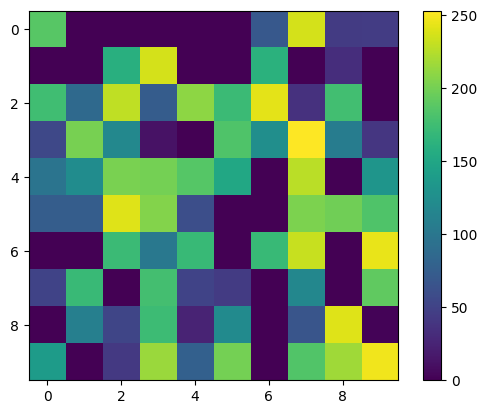

In [30]:
plt.imshow(img_tr2d.reshape((10, 10)), interpolation='nearest')
plt.colorbar()

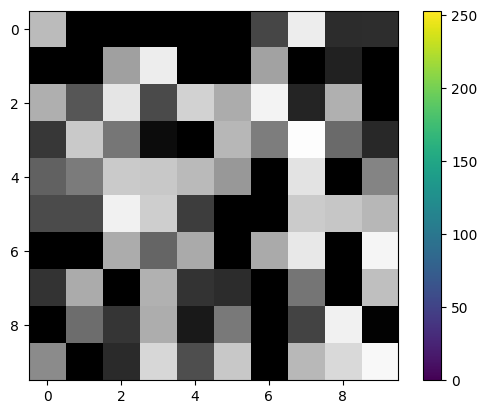

In [31]:
c = cv2.imread(save_destination)
plt.imshow(c, interpolation='nearest')
plt.colorbar()

In [33]:
from ultralytics import YOLO

# Load a model

#model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
#model = YOLO('/content/runs/classify/train2/weights/best.pt') #Load the initial weights, gained from the former model training on this data (previous line)

model = YOLO('yolov8n-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data='/content/oct_my_trdataset', epochs=100, imgsz=10, batch=64)

YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs
YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs
Transferred 158/158 items from pretrained weights
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.yaml, data=/content/oct_my_trdataset, epochs=100, time=None, patience=50, batch=64, imgsz=10, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False

100%|██████████| 6.23M/6.23M [00:00<00:00, 80.8MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[10] must be multiple of max stride 32, updating to [32]


train: Scanning /content/oct_my_trdataset/train... 1500 images, 0 corrupt: 100%|██████████| 1500/1500 [00:00<00:00, 3392.71it/s]

train: New cache created: /content/oct_my_trdataset/train.cache



val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 2337.91it/s]

val: New cache created: /content/oct_my_trdataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 32 train, 32 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100     0.264G      1.346         64         32:  33%|███▎      | 8/24 [00:02<00:02,  5.87it/s]

      1/100     0.264G      1.326         64         32:  67%|██████▋   | 16/24 [00:03<00:00,  8.52it/s]
100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]
      1/100     0.264G      1.327         28         32: 100%|██████████| 24/24 [00:04<00:00,  5.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.02it/s]

                   all       0.35          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100     0.262G      1.297         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 26.84it/s]

                   all      0.423          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100     0.262G       1.22         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 27.17it/s]

                   all      0.423          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100     0.262G      1.227         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 45.48it/s]

                   all      0.467          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100     0.262G      1.178         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.74it/s]

                   all      0.473          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100     0.262G      1.154         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 32.94it/s]

                   all       0.43          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100     0.262G      1.116         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.94it/s]

                   all       0.54          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100     0.262G      1.125         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 43.20it/s]

                   all      0.493          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100     0.262G      1.088         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 33.12it/s]

                   all       0.57          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100     0.262G      1.039         28         32: 100%|██████████| 24/24 [00:02<00:00, 10.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 22.22it/s]

                   all      0.547          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100     0.262G      1.045         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 17.28it/s]

                   all      0.607          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100     0.262G      1.064         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 21.93it/s]

                   all      0.643          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100     0.262G      1.024         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.12it/s]

                   all      0.657          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100     0.262G     0.9823         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.03it/s]

                   all       0.62          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100     0.262G     0.9346         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.15it/s]

                   all      0.677          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100     0.262G     0.9202         28         32: 100%|██████████| 24/24 [00:02<00:00, 10.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 41.24it/s]

                   all      0.693          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100     0.262G      0.936         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 52.92it/s]

                   all      0.727          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100     0.262G     0.9734         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 43.08it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100     0.262G     0.9312         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 28.85it/s]


                   all      0.727          1

      Epoch    GPU_mem       loss  Instances       Size


     20/100     0.262G     0.8921         28         32: 100%|██████████| 24/24 [00:02<00:00, 10.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 16.99it/s]

                   all      0.767          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100     0.262G     0.8961         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 26.83it/s]

                   all      0.813          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100     0.262G     0.8446         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 31.57it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100     0.262G     0.8567         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 30.72it/s]

                   all      0.813          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100     0.262G     0.8374         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 38.72it/s]

                   all      0.793          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100     0.262G     0.8302         28         32: 100%|██████████| 24/24 [00:02<00:00, 10.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.73it/s]

                   all       0.81          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100     0.262G     0.7999         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 29.89it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100     0.262G     0.8137         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 84.16it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100     0.262G     0.8235         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 36.17it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100     0.262G     0.8106         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 33.05it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100     0.262G     0.7962         28         32: 100%|██████████| 24/24 [00:02<00:00, 12.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 29.74it/s]

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100     0.262G      0.802         28         32: 100%|██████████| 24/24 [00:03<00:00,  7.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.50it/s]

                   all      0.863          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100     0.262G     0.7733         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 40.25it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100     0.262G     0.7944         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 68.37it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100     0.262G     0.7841         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 84.59it/s]

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100     0.262G     0.7581         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 29.47it/s]

                   all      0.863          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100     0.262G     0.7628         28         32: 100%|██████████| 24/24 [00:03<00:00,  7.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 20.21it/s]

                   all       0.87          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100     0.262G     0.7413         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.74it/s]

                   all       0.87          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100     0.262G     0.7443         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 48.44it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100     0.262G     0.7632         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.48it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100     0.262G     0.7269         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 32.83it/s]

                   all      0.863          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100     0.262G     0.7523         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 20.17it/s]


                   all      0.877          1

      Epoch    GPU_mem       loss  Instances       Size


     42/100     0.262G     0.7243         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 35.49it/s]


                   all      0.873          1

      Epoch    GPU_mem       loss  Instances       Size


     43/100     0.262G     0.7348         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 20.46it/s]

                   all      0.897          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100     0.262G     0.6973         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 27.20it/s]

                   all      0.893          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100     0.262G     0.7166         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 28.24it/s]

                   all       0.89          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100     0.262G     0.6875         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 22.43it/s]

                   all      0.903          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100     0.262G     0.7483         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.61it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100     0.262G     0.7131         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 32.61it/s]


                   all      0.897          1

      Epoch    GPU_mem       loss  Instances       Size


     49/100     0.262G     0.7006         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 39.33it/s]

                   all      0.897          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100     0.262G     0.7164         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 19.24it/s]

                   all      0.887          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100     0.262G     0.6982         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 37.65it/s]

                   all      0.893          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100     0.262G     0.6704         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 84.03it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100     0.262G     0.6936         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 23.58it/s]

                   all      0.903          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100     0.262G     0.6499         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 38.99it/s]


                   all        0.9          1

      Epoch    GPU_mem       loss  Instances       Size


     55/100     0.262G     0.6832         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 33.35it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100     0.262G     0.6824         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 31.77it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100     0.262G     0.6646         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 23.35it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100     0.262G     0.6893         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 33.34it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100     0.262G     0.6783         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 42.69it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100     0.262G     0.6999         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 41.23it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100     0.262G     0.6468         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 21.87it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100     0.262G     0.6384         28         32: 100%|██████████| 24/24 [00:03<00:00,  7.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 20.47it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100     0.262G     0.6659         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 31.20it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100     0.262G     0.6826         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 23.21it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100     0.262G     0.6287         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 28.70it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100     0.262G     0.6331         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 23.38it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100     0.262G     0.6068         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 36.46it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100     0.262G     0.6501         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 35.11it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100     0.262G     0.6606         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 37.57it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100     0.262G      0.609         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 22.37it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100     0.262G     0.6172         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 32.18it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100     0.262G     0.6768         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 20.68it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100     0.262G      0.648         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 28.27it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100     0.262G     0.6336         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 29.84it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100     0.262G     0.6741         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.99it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100     0.262G     0.6225         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 29.10it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100     0.262G     0.6221         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 21.54it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100     0.262G     0.6181         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 28.91it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100     0.262G     0.6352         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 41.75it/s]


                   all      0.943          1

      Epoch    GPU_mem       loss  Instances       Size


     80/100     0.262G      0.619         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 73.37it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100     0.262G     0.6099         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 35.51it/s]


                   all      0.967          1

      Epoch    GPU_mem       loss  Instances       Size


     82/100     0.262G     0.5913         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 29.21it/s]


                   all      0.957          1

      Epoch    GPU_mem       loss  Instances       Size


     83/100     0.262G     0.6029         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 23.96it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100     0.262G     0.6056         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 23.48it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100     0.262G     0.6442         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 34.75it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100     0.262G     0.5973         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 25.57it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100     0.262G     0.6016         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 33.19it/s]


                   all      0.943          1

      Epoch    GPU_mem       loss  Instances       Size


     88/100     0.262G     0.6149         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 30.24it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100     0.262G     0.5817         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.34it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100     0.262G     0.6031         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 37.49it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100     0.262G     0.6039         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 36.03it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100     0.262G     0.5942         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 34.51it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100     0.262G     0.6144         28         32: 100%|██████████| 24/24 [00:02<00:00,  8.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.79it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100     0.262G      0.614         28         32: 100%|██████████| 24/24 [00:02<00:00, 10.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 42.59it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100     0.262G      0.615         28         32: 100%|██████████| 24/24 [00:01<00:00, 12.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 36.98it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100     0.262G      0.599         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 19.84it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100     0.262G     0.5992         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 39.12it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100     0.262G      0.603         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.06it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100     0.262G     0.5878         28         32: 100%|██████████| 24/24 [00:02<00:00,  9.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 24.20it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100     0.262G     0.5948         28         32: 100%|██████████| 24/24 [00:02<00:00, 11.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 34.48it/s]

                   all      0.957          1



100 epochs completed in 0.076 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


                   all      0.967          1
Speed: 0.0ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


In [34]:
# Validate the modelblob:https://colab.research.google.com/f8428635-acf6-400f-b52f-379198002792
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


                   all      0.967          1
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train22


0.9666666984558105

In [ ]:
# @title Predict using the model



In [35]:
#test_score = model.predict(source='/content/oct_my_trdataset/test/Normal')
#0:AMD 1:DME 2:Normal
label_predict = []
label_conf = []
label_true = []

test_path = '/content/oct_my_trdataset/test/'

for subfolder in ['Normal', 'DME', 'AMD']:
  test_img_dir = os.path.join(test_path, subfolder)
  test_img = model(test_img_dir)

  for num in range(200):
    label_true.append(subfolder)
    label_predict.append(test_img[num].names[test_img[num].probs.top1])
    label_conf.append(test_img[num].probs.top1conf)

print(label_true)
print(label_predict)
print(label_conf)


image 1/200 /content/oct_my_trdataset/test/Normal/1.TIFF: 32x32 Normal 0.99, AMD 0.01, DME 0.00, 3.0ms
image 2/200 /content/oct_my_trdataset/test/Normal/100.TIFF: 32x32 Normal 0.83, AMD 0.10, DME 0.07, 3.5ms
image 3/200 /content/oct_my_trdataset/test/Normal/1001.TIFF: 32x32 Normal 0.94, AMD 0.05, DME 0.01, 3.2ms
image 4/200 /content/oct_my_trdataset/test/Normal/1013.TIFF: 32x32 Normal 0.99, AMD 0.01, DME 0.00, 3.7ms
image 5/200 /content/oct_my_trdataset/test/Normal/1019.TIFF: 32x32 Normal 0.83, AMD 0.16, DME 0.01, 4.1ms
image 6/200 /content/oct_my_trdataset/test/Normal/1020.TIFF: 32x32 Normal 0.98, AMD 0.02, DME 0.00, 4.8ms
image 7/200 /content/oct_my_trdataset/test/Normal/1024.TIFF: 32x32 Normal 0.93, DME 0.05, AMD 0.03, 2.9ms
image 8/200 /content/oct_my_trdataset/test/Normal/103.TIFF: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 3.5ms
image 9/200 /content/oct_my_trdataset/test/Normal/1032.TIFF: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 4.0ms
image 10/200 /content/oct_my_trdataset/test/Normal

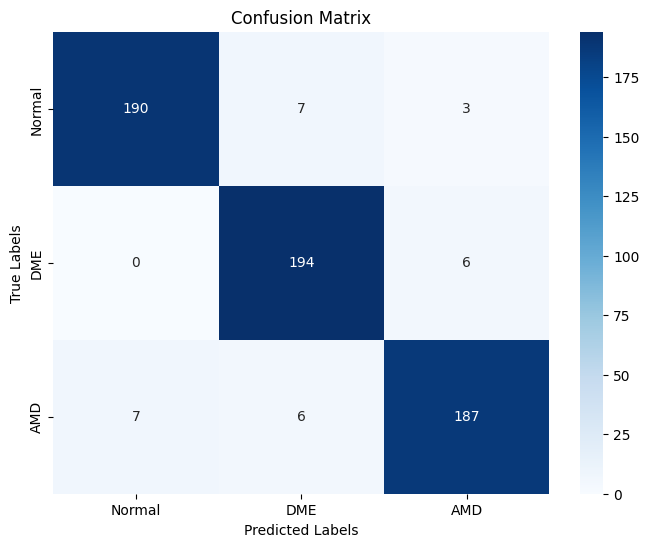

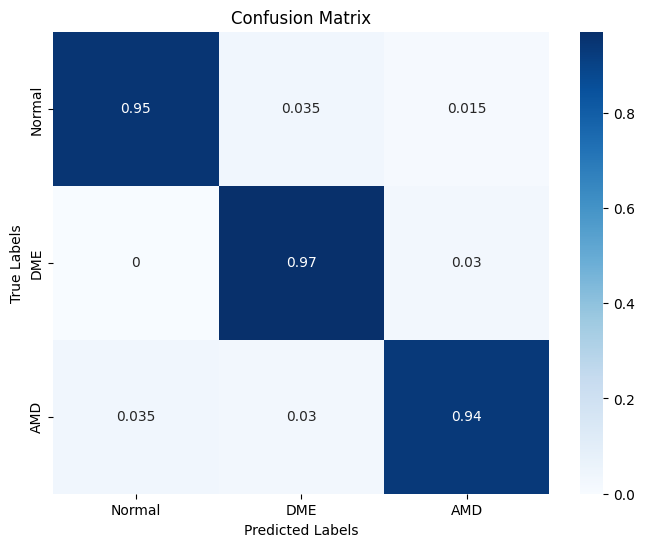

True

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


conf_matrix = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'])
conf_matrix_norm = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'], normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_image = np.array(heatmap.get_figure().canvas.renderer.buffer_rgba())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap_norm = sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_norm_image = np.array(heatmap_norm.get_figure().canvas.renderer.buffer_rgba())

cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix.jpeg', heatmap_image)
cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix_norm.jpeg', heatmap_norm_image)

In [ ]:
#@title Inference time calculation on the test data

In [37]:
import os
import datetime
import numpy as np
import cv2
!pip install ultralytics
from ultralytics import YOLO
from joblib import load

#import pickle
#import joblib
#Normal_model = load('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/atoms/dl_model_NORMAL.joblib')
#DME_model = load('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/atoms/dl_model_DME.joblib')
#AMD_model = load('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/atoms/dl_model_AMD.joblib')

Normal_model = dl_model_NORMAL
DME_model = dl_model_DME
AMD_model = dl_model_AMD

model_dict = [Normal_model, DME_model, AMD_model]
model_classification = YOLO('/content/runs/classify/train2/weights/best.pt') # build from YAML and transfer weights


In [38]:
#Define an inference time function
def inference(img, model_dict, model_classification):
  start_time = datetime.datetime.now()

  # your functions
  #data transforming using dictionary learning
  img = np.asarray(img) # convert it to ndarray
  img = cv2.resize(img, (512, 512))
  img = img.reshape((1, 512 * 512))
  img = img.astype(float)
  img /= 255.0

  label_conf = []
  label_predict = []
  for dict_num in model_dict:
    img_tr = dict_num.transform(img)
    img_tr2d = img_tr.reshape((10, 10))*255
    img_tr2d = img_tr2d.astype(np.uint8)

    #predict the class using YOLOv8
    classification_result = model_classification(img_tr2d)
    label_conf.append(classification_result[0].probs.top1conf)
    label_predict.append(classification_result[0].names[classification_result[0].probs.top1])

  index = label_conf.index(max(label_conf))
  final_label = label_predict[index]




  end_time = datetime.datetime.now()
  elapsed_time = end_time - start_time
  #print(f"{elapsed_time=}")

  return final_label, elapsed_time


In [39]:
#Images importing
from PIL import Image

img_list = []
dataset_folder = '/content/oct_my_trdataset/test/'  # Replace with your source folder path
for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_open = os.listdir(source_folder)

  # Open each image file from the source folder
  for img_name in files_to_open[:10]:
    img_dir = os.path.join(source_folder, img_name)
    image = Image.open(img_dir) # This returns an image object
    img_list.append(image)

In [40]:
#Inference time calculation

label_list = []
inference_list = []
for img in img_list:
  label, time = inference(img, model_dict, model_classification)
  label_list.append(label)
  inference_list.append(time)


0: 32x32 Normal 0.99, AMD 0.00, DME 0.00, 4.1ms
Speed: 5.1ms preprocess, 4.1ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.58, Normal 0.24, AMD 0.17, 4.4ms
Speed: 6.3ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.95, Normal 0.03, DME 0.01, 4.5ms
Speed: 4.9ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.51, DME 0.49, AMD 0.00, 4.8ms
Speed: 5.5ms preprocess, 4.8ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 1.00, AMD 0.00, Normal 0.00, 4.8ms
Speed: 4.3ms preprocess, 4.8ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 1.00, DME 0.00, Normal 0.00, 4.5ms
Speed: 4.6ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.64, DME 0.33, AMD 0.03, 7.5ms
Speed: 4.4ms preprocess, 7.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 1.00, AMD 0.00, Normal 0.00, 4.6ms
Speed: 4.5ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.98, Normal 0.02, DME 0.00, 4.8ms
Speed: 5.0ms preprocess, 4.8ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.39, Normal 0.35, DME 0.26, 4.5ms
Speed: 4.7ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.93, AMD 0.05, Normal 0.02, 4.4ms
Speed: 4.5ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.99, Normal 0.01, DME 0.00, 4.6ms
Speed: 3.5ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 4.8ms
Speed: 2.7ms preprocess, 4.8ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


0: 32x32 DME 0.99, Normal 0.00, AMD 0.00, 4.7ms
Speed: 5.4ms preprocess, 4.7ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 AMD 0.96, DME 0.02, Normal 0.01, 5.3ms
Speed: 2.3ms preprocess, 5.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.99, DME 0.00, AMD 0.00, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.96, Normal 0.04, AMD 0.01, 4.4ms
Speed: 1.9ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.58, Normal 0.30, DME 0.12, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.98, DME 0.02, AMD 0.00, 4.9ms
Speed: 1.7ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 1.00, AMD 0.00, Normal 0.00, 4.5ms
Speed: 1.7ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.89, Normal 0.10, DME 0.00, 4.6ms
Speed: 1.6ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.94, DME 0.05, AMD 0.01, 4.5ms
Speed: 1.7ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.99, Normal 0.01, AMD 0.00, 4.7ms
Speed: 1.7ms preprocess, 4.7ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.99, DME 0.01, Normal 0.00, 4.4ms
Speed: 1.8ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.57, Normal 0.30, AMD 0.13, 4.5ms
Speed: 1.7ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.52, Normal 0.43, AMD 0.06, 4.6ms
Speed: 1.7ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.99, Normal 0.01, DME 0.00, 4.4ms
Speed: 1.6ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.69, DME 0.31, AMD 0.00, 4.4ms
Speed: 2.7ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.97, Normal 0.01, AMD 0.01, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.40, AMD 0.33, Normal 0.28, 4.5ms
Speed: 1.8ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 5.3ms
Speed: 2.6ms preprocess, 5.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.93, AMD 0.07, Normal 0.00, 4.5ms
Speed: 1.7ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.95, DME 0.04, Normal 0.01, 4.6ms
Speed: 2.4ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 Normal 1.00, DME 0.00, AMD 0.00, 4.9ms
Speed: 2.7ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


0: 32x32 DME 0.93, AMD 0.06, Normal 0.01, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 AMD 0.95, Normal 0.04, DME 0.01, 4.6ms
Speed: 1.6ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, DME 0.00, AMD 0.00, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.96, AMD 0.03, Normal 0.02, 4.6ms
Speed: 4.7ms preprocess, 4.6ms inference, 9.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.98, DME 0.02, Normal 0.01, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.57, AMD 0.37, DME 0.06, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 1.00, Normal 0.00, AMD 0.00, 7.1ms
Speed: 3.9ms preprocess, 7.1ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.97, Normal 0.03, DME 0.00, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.90, Normal 0.06, AMD 0.04, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 3.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.98, Normal 0.01, DME 0.00, 7.0ms
Speed: 5.8ms preprocess, 7.0ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.97, DME 0.03, AMD 0.01, 5.4ms
Speed: 3.1ms preprocess, 5.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 1.00, AMD 0.00, Normal 0.00, 4.4ms
Speed: 1.9ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.70, AMD 0.27, Normal 0.03, 4.4ms
Speed: 1.8ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.98, AMD 0.01, Normal 0.01, 5.9ms
Speed: 4.9ms preprocess, 5.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.62, DME 0.33, Normal 0.05, 4.4ms
Speed: 1.6ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 1.00, AMD 0.00, Normal 0.00, 5.0ms
Speed: 2.1ms preprocess, 5.0ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.87, DME 0.11, Normal 0.02, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, DME 0.00, AMD 0.00, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.99, AMD 0.01, Normal 0.00, 5.2ms
Speed: 1.9ms preprocess, 5.2ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.94, Normal 0.05, DME 0.01, 4.7ms
Speed: 1.8ms preprocess, 4.7ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 5.1ms
Speed: 1.9ms preprocess, 5.1ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.92, AMD 0.06, Normal 0.02, 4.7ms
Speed: 1.9ms preprocess, 4.7ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.61, DME 0.28, Normal 0.11, 4.3ms
Speed: 1.6ms preprocess, 4.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.95, DME 0.03, AMD 0.02, 4.4ms
Speed: 1.8ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.79, AMD 0.20, Normal 0.01, 4.7ms
Speed: 1.8ms preprocess, 4.7ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.90, AMD 0.08, Normal 0.02, 4.5ms
Speed: 1.9ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.82, AMD 0.15, DME 0.04, 4.6ms
Speed: 1.8ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.99, Normal 0.01, AMD 0.00, 4.4ms
Speed: 1.8ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


0: 32x32 AMD 0.88, DME 0.07, Normal 0.05, 4.4ms
Speed: 1.8ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 Normal 0.93, AMD 0.04, DME 0.03, 4.5ms
Speed: 1.8ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.99, AMD 0.00, Normal 0.00, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 AMD 0.94, Normal 0.06, DME 0.00, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 1.00, AMD 0.00, DME 0.00, 4.9ms
Speed: 1.8ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.98, AMD 0.01, Normal 0.01, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.55, AMD 0.45, Normal 0.00, 4.5ms
Speed: 1.7ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.98, DME 0.02, AMD 0.00, 4.6ms
Speed: 1.8ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.97, AMD 0.02, Normal 0.01, 4.5ms
Speed: 1.6ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.98, Normal 0.02, DME 0.00, 4.4ms
Speed: 1.6ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.81, DME 0.18, AMD 0.01, 4.4ms
Speed: 1.7ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.96, AMD 0.04, Normal 0.00, 4.4ms
Speed: 1.6ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.82, DME 0.11, Normal 0.07, 4.4ms
Speed: 2.0ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.99, AMD 0.00, DME 0.00, 4.4ms
Speed: 2.0ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.55, AMD 0.44, Normal 0.00, 4.6ms
Speed: 2.3ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


0: 32x32 AMD 0.95, DME 0.03, Normal 0.02, 6.4ms
Speed: 8.3ms preprocess, 6.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 Normal 0.84, DME 0.11, AMD 0.05, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.75, Normal 0.13, AMD 0.12, 4.4ms
Speed: 2.2ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.95, Normal 0.03, DME 0.02, 4.6ms
Speed: 2.4ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.95, DME 0.05, AMD 0.00, 4.6ms
Speed: 2.8ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.68, AMD 0.18, Normal 0.13, 4.4ms
Speed: 2.2ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 AMD 0.92, DME 0.07, Normal 0.01, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 Normal 0.93, DME 0.04, AMD 0.03, 4.6ms
Speed: 2.1ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(



0: 32x32 DME 0.89, Normal 0.06, AMD 0.05, 5.3ms
Speed: 3.5ms preprocess, 5.3ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 AMD 0.98, Normal 0.01, DME 0.01, 4.6ms
Speed: 2.5ms preprocess, 4.6ms inference, 0.1ms postprocess per image at shape (1, 3, 32, 32)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [41]:
#print the inference time
inference_mean = np.mean(inference_list)
print(f"{inference_mean=}")

inference_mean=datetime.timedelta(microseconds=721668)


In [ ]:
#@title Save folders and experiments on the Google Drive

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset')

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dictl_dataset')

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset')

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/atoms')

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs')

In [ ]:
#copy folders to google drive
shutil.copytree("/content/oct_my_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/oct_my_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/oct_my_dataset'

In [ ]:
shutil.copytree("/content/oct_my_dictl_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/oct_my_dictl_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/oct_my_dictl_dataset'

In [42]:
shutil.copytree("/content/oct_my_trdataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/oct_my_trdataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/oct_my_trdataset'

In [43]:
shutil.copytree("/content/atoms", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/atoms")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/atoms'

In [44]:
shutil.copytree("/content/runs", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/runs")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test18/runs'

In [ ]:
#@title More simpler YOLO implementation prompts

In [ ]:
#train
!yolo task=classify mode=predict model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' data='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset' epochs = 10 imgsz=512

In [ ]:
#validation
!yolo task=classify mode=val model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' data='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset'

In [ ]:
#prediction
!yolo task=classify mode=predict model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' source='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset/test/AMD' conf = 0.25

In [ ]:
#export
!yolo export model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' format = onnx

In [ ]:
#Download the model
from google.colab import files
files.download(='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.onnx')


In [ ]:
#@title Dictlearn tests - incomplete

In [ ]:
!git clone https://github.com/permfl/dictlearn.git /content/dictlearn

Cloning into '/content/dictlearn'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 152 (delta 1), reused 2 (delta 0), pack-reused 145
Receiving objects: 100% (152/152), 2.11 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
!pip install dictlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
%cd /content/dictlearn
!pip install --file requirements.txt

/content/dictlearn

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --file


In [ ]:
!python setup.py install

Installing dictlearn...
Compiling /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx because it changed.
Compiling /content/dictlearn/dictlearn/_dictlearn/hessian.pyx because it changed.
[1/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
/usr/local/lib/python3.10/dist-packag

In [ ]:
import dictlearn as dl
dictionary = dl.dct_dict(256, 8)

AttributeError: module 'dictlearn' has no attribute 'dct_dict'

In [ ]:
import dictlearn as dl
dl.
image = dl.imread('examples/images/house.png')
image_patches = dl.Patches(image, 8)
matrix = image_patches.patches
matrix.shape

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl

denoise = dl.Denoise('noisy_image.png')
denoised_image = denoise.train().denoise()
plt.imshow(denoised_image)
plt.show()

AttributeError: module 'dictlearn' has no attribute 'Denoise'

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [ ]:
!pip show dictlearn

Name: dictlearn
Version: 0.2.1
Summary: Dictionary Learning Toolbox
Home-page: https://gitlab.com/unibuc/graphomaly/dictionary-learning
Author: Paul Irofti, Denis Ilie-Ablachim, Bogdan Dumitrescu
Author-email: graphomaly@fmi.unibuc.ro
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, scipy
Required-by: 


In [ ]:
print(dir(dl))
dl.kernels()

['DictionaryLearning', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_dictionary_learning', '_get_fit_handle', 'dictionary_learning', 'kernel_dictionary_learning', 'kernels', 'methods', 'online_dictionary_learning', 'sparse_encode']


In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl
dl.
inpainter = dl.inpaint('image.png', 'mask.png')
inpainted_image = inpainter.train().inpaint()

plt.subplot(121)
plt.imshow(inpainter.patches.image)
plt.title('Original')

plt.subplot(122)
plt.imshow(inpainted_image)
plt.title('Inpainted')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'inpaint'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2


image = cv2.imread('images/vessel.png')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True, n_init=3)
patch_size = (30, 30)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  100 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  300 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  400 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Part

In [ ]:
a = faces.images

In [ ]:
a.dtype

dtype('float32')

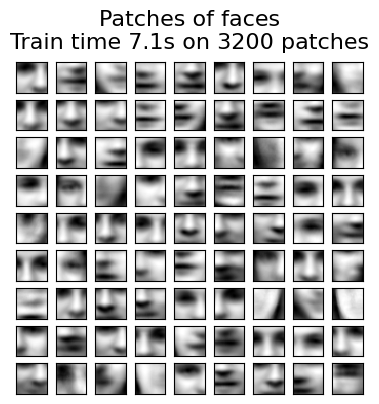

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()